### Modeling voltage threshold classification at 2.5 V using XGBoost with SELFIES and bianry data (augmentation applied)

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import saved files
train_df = pd.read_csv('train_df_Agmt_Rdkit.csv')
test_df = pd.read_csv('test_df_Agmt_Rdkit.csv')
augmented_df = pd.read_csv('augmented_df_All_Rdkit.csv')

In [3]:
augmented_df.shape

(1453, 2)

In [4]:
augmented_df.head()

,SMILES,Voltage
0,Clc1c([H])c([H])c(Cl)c2c1C(=O)C([H])=C([H])C2=O,2.663037
1,O=c1c(Cl)c([H])c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,3.655935
2,[Li]OC(C1=C(C(O[Li])(O[Li])[H])SC(=C2SC(C(O[Li...,1.200000
3,Fc1c([H])c(S[Li])c(F)c([H])c1S[Li],2.400000
4,C(Oc1c(OC([H])([H])[H])c([H])c([H])c2c([H])c(O...,2.670670


In [5]:
train_df.head()

,Voltage,SMILES,smiles,Voltage_Binned
0,2.663037,Clc1ccc(Cl)c(c12)C(=O)C=CC2=O,O=C1C=CC(=O)c2c(Cl)ccc(Cl)c21,low
1,3.655935,O=c1c(Cl)cc(=O)c(c12)c(=O)c(Cl)c(Cl)c2=O,O=c1cc(Cl)c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,high
2,1.200000,[Li]OC(C1=C(S/C(S1)=C2SC(C(O[Li])O[Li])=C(S/2)...,[Li]OC(O[Li])C1=C(C(O[Li])O[Li])SC(=C2SC(C(O[L...,very low
3,2.400000,FC(C=C1S[Li])=C(C=C1F)S[Li],[Li]Sc1cc(F)c(S[Li])cc1F,low
4,2.670670,COc1c(OC)ccc2cc(OC)c(c3c12)/C(=N/S(=O)(=O)C)/C...,COC1=C(OC)c2c(c(OC)cc3ccc(OC)c(OC)c23)C(=N/S(C...,low


In [6]:
train_df.shape

(1690, 4)

In [7]:
test_df.shape

(725, 4)

In [8]:
# Delete 'Voltage_Binned' column from both train_df and test_df
train_df = train_df.drop(columns=['Voltage_Binned'])
test_df = test_df.drop(columns=['Voltage_Binned'])

In [9]:

# Step 3: Merge augmented data with original train data and test data
augmented_df['Augmented'] = 1
train_df['Augmented'] = 1
test_df['Augmented'] = 0
df_All_augmented = pd.concat([augmented_df,train_df, test_df], ignore_index=True)


In [10]:
df_All_augmented.head()

,SMILES,Voltage,Augmented,smiles
0,Clc1c([H])c([H])c(Cl)c2c1C(=O)C([H])=C([H])C2=O,2.663037,1,NaN
1,O=c1c(Cl)c([H])c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,3.655935,1,NaN
2,[Li]OC(C1=C(C(O[Li])(O[Li])[H])SC(=C2SC(C(O[Li...,1.200000,1,NaN
3,Fc1c([H])c(S[Li])c(F)c([H])c1S[Li],2.400000,1,NaN
4,C(Oc1c(OC([H])([H])[H])c([H])c([H])c2c([H])c(O...,2.670670,1,NaN


In [11]:
df_All_augmented.shape

(4105, 4)

In [12]:
df_All_augmented = df_All_augmented.drop_duplicates(subset='SMILES', keep='first')

In [13]:
df_All_augmented.shape

(4090, 4)

In [14]:
df_All = df_All_augmented.copy()

In [15]:
df_All.shape

(4090, 4)

### Exploratory Data Analysis (EDA)

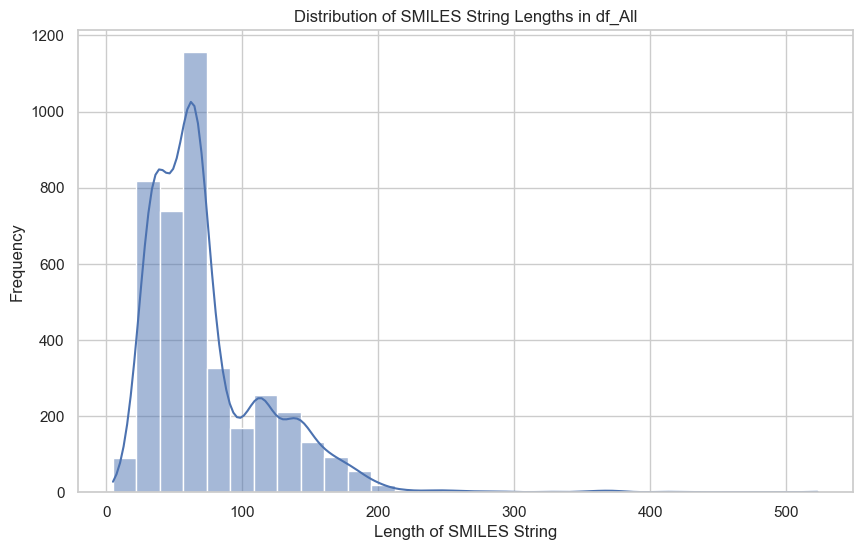

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each SMILES string
df_All['length'] = df_All['SMILES'].apply(len)

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(df_All['length'], bins=30, kde=True)

# Set the plot title and labels
plt.title('Distribution of SMILES String Lengths in df_All')
plt.xlabel('Length of SMILES String')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [17]:
max_length_All = df_All['SMILES'].apply(len).max()

print("The maximum length of SMILES strings in the df_All DataFrame is:", max_length_All)

The maximum length of SMILES strings in the df_All DataFrame is: 523


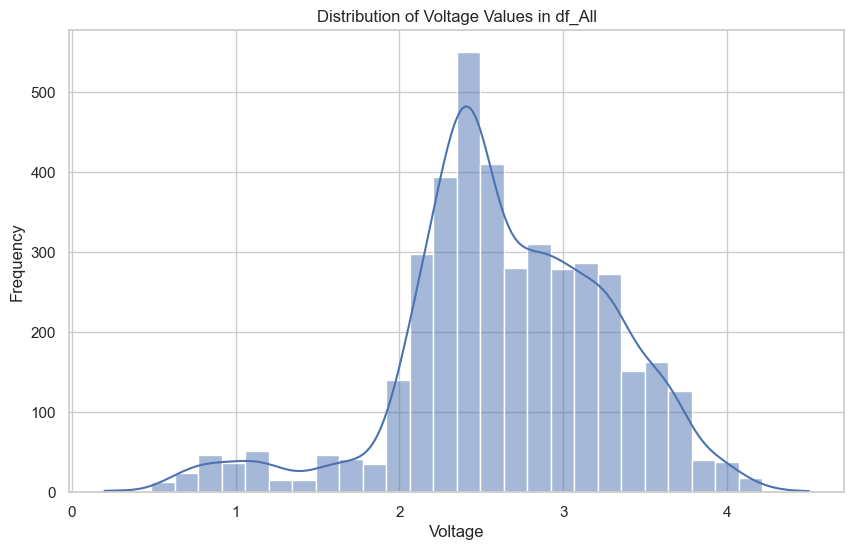

In [18]:
# Create the plot for Voltage distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_All['Voltage'], bins=30, kde=True)
plt.title('Distribution of Voltage Values in df_All')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Filter the DataFrame for voltage values greater than 2.5
high_voltage_df_All = df_All[df_All['Voltage'] > 2.5]

# Count the number of rows with voltage values greater than 2.5
num_high_voltage_All = high_voltage_df_All.shape[0]

percent_All = round((num_high_voltage_All/df_All.shape[0]) * 100, 2)

print(f"Number of voltage values in df_All greater than 2.5: {num_high_voltage_All}")
print(f"Percentage: {percent_All}%")

Number of voltage values in df_All greater than 2.5: 2268
Percentage: 55.45%


In [20]:
Voltage_threshold = 2.5

df_All['target'] = (df_All['Voltage'] > Voltage_threshold).astype(int)

In [21]:
df_All = df_All[df_All['length'] <= 250]

In [22]:
df_All.shape

(4073, 6)

In [23]:
df_All.head()

,SMILES,Voltage,Augmented,smiles,length,target
0,Clc1c([H])c([H])c(Cl)c2c1C(=O)C([H])=C([H])C2=O,2.663037,1,NaN,47,1
1,O=c1c(Cl)c([H])c(=O)c2c(=O)c(Cl)c(Cl)c(=O)c1=2,3.655935,1,NaN,46,1
2,[Li]OC(C1=C(C(O[Li])(O[Li])[H])SC(=C2SC(C(O[Li...,1.200000,1,NaN,97,0
3,Fc1c([H])c(S[Li])c(F)c([H])c1S[Li],2.400000,1,NaN,34,0
4,C(Oc1c(OC([H])([H])[H])c([H])c([H])c2c([H])c(O...,2.670670,1,NaN,178,1


In [24]:
# Reset the index of df_All after deleting columns
df_All = df_All.reset_index(drop=True)

# Sanitization - SELFIES - Encoding

In [25]:
import pandas as pd
import selfies as sf
from rdkit import Chem
from rdkit.Chem import MolToSmiles
from rdkit import RDLogger
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.error')

class SMILESToSELFIESTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pad_to_len=None):
        self.pad_to_len = pad_to_len
        self.symbol_to_idx = None
        self.idx_to_symbol = None

    def sanitize_smiles(self, smiles):
        try:
            # Replace '.' with 'X'
            smiles = smiles.replace('.', 'X')
            mol = Chem.MolFromSmiles(smiles, sanitize=True)
            if mol is not None:
                return MolToSmiles(mol, canonical=True)
            else:
                return None
        except:
            return None

    def smiles_to_selfies(self, smiles):
        sanitized_smiles = self.sanitize_smiles(smiles)
        if sanitized_smiles:
            try:
                return sf.encoder(sanitized_smiles)
            except sf.EncoderError:
                return None
        return None

    def build_vocabulary(self, selfies_list):
        alphabet = sf.get_alphabet_from_selfies(selfies_list)
        alphabet.add("[nop]")  # [nop] is a special padding symbol
        self.alphabet = list(sorted(alphabet))
        self.symbol_to_idx = {s: i for i, s in enumerate(self.alphabet)}
        self.idx_to_symbol = {i: s for i, s in enumerate(self.alphabet)}

    def selfies_to_numerical(self, selfies):
        if not self.symbol_to_idx:
            raise ValueError("Vocabulary is not built. Call build_vocabulary first.")
        label, one_hot = sf.selfies_to_encoding(
            selfies=selfies,
            vocab_stoi=self.symbol_to_idx,
            pad_to_len=self.pad_to_len,
            enc_type="both"
        )
        return label

    def print_alphabet_list(self):
        if self.alphabet:
            print("Alphabet list:", self.alphabet)
        else:
            print("Alphabet list has not been built yet.")
    
    def fit(self, X, y=None):
        X = X.copy()
        # Convert SMILES to SELFIES
        X['selfies'] = X['smiles'].apply(self.smiles_to_selfies)
        
        # Filter out rows with invalid SELFIES
        X = X.dropna(subset=['selfies'])

        # Build vocabulary
        selfies_list = X['selfies'].tolist()
        self.build_vocabulary(selfies_list)

        # Determine pad_to_len if not specified
        if self.pad_to_len is None:
            self.pad_to_len = max(sf.len_selfies(s) for s in selfies_list)
        
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Convert SMILES to SELFIES (if not already done in fit)
        if 'selfies' not in X.columns:
            X['selfies'] = X['smiles'].apply(self.smiles_to_selfies)
        
        # Filter out rows with invalid SELFIES
        X = X.dropna(subset=['selfies'])

        # Convert SELFIES to numerical IDs
        X['numerical_ids'] = X['selfies'].apply(self.selfies_to_numerical)
        
        #return X[['numerical_ids']]

        # Convert the list of numerical IDs into a DataFrame
        numerical_ids_df = pd.DataFrame(X['numerical_ids'].tolist())
        
        return numerical_ids_df

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


In [26]:
# Show full length
pd.set_option('display.max_colwidth', None)

#### IDs for df_All

In [27]:
df_trans_All = pd.DataFrame()
df_trans_All['smiles'] = df_All['SMILES']
trans_All = SMILESToSELFIESTransformer()
IDs_All = trans_All.fit_transform(df_trans_All)

In [28]:
# Retrieve the calculated pad_to_len
print("Computed pad_to_len:", trans_All.pad_to_len)

Computed pad_to_len: 175


In [29]:
IDs_All.head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,38,12,26,12,26,10,26,15,26,12,...,49,49,49,49,49,49,49,49,49,49
1,38,12,26,12,22,26,27,26,10,26,...,49,49,49,49,49,49,49,49,49,49
2,30,38,26,22,40,38,30,26,12,22,...,49,49,49,49,49,49,49,49,49,49
3,30,43,26,12,26,22,26,28,12,22,...,49,49,49,49,49,49,49,49,49,49
4,26,38,26,12,22,40,38,26,26,12,...,49,49,49,49,49,49,49,49,49,49


In [30]:
# Call print_alphabet_list() to print the alphabet list
trans_All.print_alphabet_list()

Alphabet list: ['[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[-\\Ring1]', '[-\\Ring2]', '[/C]', '[/N]', '[/O]', '[/S]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S]', '[B]', '[Br]', '[Branch1]', '[Branch2]', '[C@@H1]', '[C@H1]', '[C]', '[Cl]', '[F]', '[I]', '[Li]', '[N+1]', '[N-1]', '[NH1]', '[N]', '[Na]', '[O-1]', '[OH0]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S+1]', '[S]', '[\\C]', '[\\F]', '[\\N]', '[\\O]', '[\\S]', '[nop]']


In [31]:
trans_All.fit(df_trans_All)

SMILESToSELFIESTransformer(pad_to_len=175)

In [32]:
# Print the mapping from numerical IDs to SELFIES tokens
print("Numerical ID to Token mapping for df_P:")
for idx, token in trans_All.idx_to_symbol.items():
    print(f"ID {idx}: {token}")

Numerical ID to Token mapping for df_P:
ID 0: [#Branch1]
ID 1: [#Branch2]
ID 2: [#C]
ID 3: [#N]
ID 4: [-\Ring1]
ID 5: [-\Ring2]
ID 6: [/C]
ID 7: [/N]
ID 8: [/O]
ID 9: [/S]
ID 10: [=Branch1]
ID 11: [=Branch2]
ID 12: [=C]
ID 13: [=N+1]
ID 14: [=N]
ID 15: [=O]
ID 16: [=P]
ID 17: [=Ring1]
ID 18: [=Ring2]
ID 19: [=S]
ID 20: [B]
ID 21: [Br]
ID 22: [Branch1]
ID 23: [Branch2]
ID 24: [C@@H1]
ID 25: [C@H1]
ID 26: [C]
ID 27: [Cl]
ID 28: [F]
ID 29: [I]
ID 30: [Li]
ID 31: [N+1]
ID 32: [N-1]
ID 33: [NH1]
ID 34: [N]
ID 35: [Na]
ID 36: [O-1]
ID 37: [OH0]
ID 38: [O]
ID 39: [P]
ID 40: [Ring1]
ID 41: [Ring2]
ID 42: [S+1]
ID 43: [S]
ID 44: [\C]
ID 45: [\F]
ID 46: [\N]
ID 47: [\O]
ID 48: [\S]
ID 49: [nop]


#### Save and reuse embeddings

Using the same embedding, alphabet list, length, and padding from your trained SMILESToSELFIESTransformer class for screening molecules in a database

Save the Fitted Transformer Information: After fitting the transformer on your current dataset, save the vocabulary (symbol_to_idx, idx_to_symbol), alphabet, and pad_to_len. This ensures consistency when transforming the SMILES data from the new database.

In [33]:
import pickle

# After fitting the transformer
transformer = SMILESToSELFIESTransformer(pad_to_len=175)
transformer.fit(df_trans_All)

# Save the transformer state
with open('transformer_state.pkl', 'wb') as f:
    pickle.dump({
        'symbol_to_idx': transformer.symbol_to_idx,
        'idx_to_symbol': transformer.idx_to_symbol,
        'alphabet': transformer.alphabet,
        'pad_to_len': transformer.pad_to_len
    }, f)


Load the Fitted Transformer Information: When applying the transformer to the new dataset (e.g., the database of molecules), load the saved transformer state and use the same settings (vocabulary, padding length, etc.).

In [ ]:
'''
# Load the transformer state
with open('transformer_state.pkl', 'rb') as f:
    state = pickle.load(f)

# Initialize transformer with saved state
transformer = SMILESToSELFIESTransformer(pad_to_len=state['pad_to_len'])
transformer.symbol_to_idx = state['symbol_to_idx']
transformer.idx_to_symbol = state['idx_to_symbol']
transformer.alphabet = state['alphabet']

# Transform the new database (df_new)
df_new_numerical_ids = transformer.transform(df_new)

'''

In [34]:
IDs_All.shape

(4073, 175)

Given that the IDs_All dataframe has 175 columns (with column names ranging from 0 to 174), and it contains padded SMILES numerical IDs, we can modify the code to work directly with this dataframe. The goal is to create binary features based on whether any of the numerical IDs (from 0 to 48) appear in each row of IDs_All.

In [35]:
# Alphabet list size (0 to 48)
alphabet_size = 49

# Initialize a new DataFrame to store the binary features (columns: 0 to 48)
binary_features_df = pd.DataFrame(0, index=IDs_All.index, columns=range(alphabet_size))

# Function to create a binary vector for each row in IDs_All
def create_binary_vector(row, alphabet_size):
    binary_vector = [0] * alphabet_size
    for num_id in row:
        if 0 <= num_id < alphabet_size:  # Only consider IDs from 0 to 48
            binary_vector[num_id] = 1
    return binary_vector

# Apply the function to each row of IDs_All
for idx, row in IDs_All.iterrows():
    binary_features_df.loc[idx] = create_binary_vector(row, alphabet_size)



In [36]:
binary_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,1,...,0,1,1,0,1,0,0,0,0,0


In [37]:
binary_features_df.shape

(4073, 49)

In [38]:
# Alphabet list from 0 to 48, corresponding to the numerical IDs
alphabet_list = ['[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[-\\Ring1]', '[-\\Ring2]', '[/C]', '[/N]', '[/O]', '[/S]', 
                 '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S]',
                 '[B]', '[Br]', '[Branch1]', '[Branch2]', '[C@@H1]', '[C@H1]', '[C]', '[Cl]', '[F]', '[I]', '[Li]', 
                 '[N+1]', '[N-1]', '[NH1]', '[N]', '[Na]', '[O-1]', '[OH0]', '[O]', '[P]', '[Ring1]', '[Ring2]', 
                 '[S+1]', '[S]', '[\\C]', '[\\F]', '[\\N]', '[\\O]', '[\\S]']

# Assign the alphabet_list as the column names for binary_features_df
binary_features_df.columns = alphabet_list


In [39]:
binary_features_df.head()

,[#Branch1],[#Branch2],[#C],[#N],[-\Ring1],[-\Ring2],[/C],[/N],[/O],[/S],...,[P],[Ring1],[Ring2],[S+1],[S],[\C],[\F],[\N],[\O],[\S]
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,1,...,0,1,1,0,1,0,0,0,0,0


In [40]:
IDs_All = pd.concat([IDs_All, binary_features_df], axis=1)

# Convert all column names to strings
IDs_All.columns = IDs_All.columns.astype(str)

# Now, the column names are all strings and compatible with ML libraries


In [41]:
IDs_All.shape

(4073, 224)

In [42]:
# Assign 'Augmented' and 'target' columns from df_All to IDs_All
IDs_All[['Augmented', 'target']] = df_All[['Augmented', 'target']]


In [43]:
IDs_All.head()

,0,1,2,3,4,5,6,7,8,9,...,[Ring2],[S+1],[S],[\C],[\F],[\N],[\O],[\S],Augmented,target
0,38,12,26,12,26,10,26,15,26,12,...,0,0,0,0,0,0,0,0,1,1
1,38,12,26,12,22,26,27,26,10,26,...,0,0,1,0,0,0,0,0,1,1
2,30,38,26,22,40,38,30,26,12,22,...,1,0,1,0,0,0,0,0,1,0
3,30,43,26,12,26,22,26,28,12,22,...,0,0,1,0,0,0,0,0,1,0
4,26,38,26,12,22,40,38,26,26,12,...,1,0,1,0,0,0,0,0,1,1


### XGBoost

In [44]:
# Split IDs_All into train and test based on the 'Augmented' column
train_df = IDs_All[IDs_All['Augmented'] == 1]
test_df = IDs_All[IDs_All['Augmented'] == 0]

In [45]:
train_df.shape

(3349, 226)

In [46]:
test_df.shape

(724, 226)

In [47]:
train_df.to_csv('train_df_IDs.csv', index=False)
test_df.to_csv('test_df_IDs.csv', index=False)

In [3]:
train_df = pd.read_csv('train_df_IDs.csv')
test_df = pd.read_csv('test_df_IDs.csv')

In [4]:
train_df.shape

(3349, 226)

In [5]:
test_df.shape

(724, 226)

In [6]:
# Define X_train as the feature columns (exclude 'target' and 'Augmented')
X_train_All = train_df.drop(columns=['target', 'Augmented'])

# Define y_train as the 'target' column
y_train_All = train_df['target']


In [7]:
# Define X_test as the feature columns (exclude 'target' and 'Augmented')
X_test_All = test_df.drop(columns=['target', 'Augmented'])

# Define y_test as the 'target' column
y_test_All = test_df['target']

In [52]:
X_train_All.head()

,0,1,2,3,4,5,6,7,8,9,...,[P],[Ring1],[Ring2],[S+1],[S],[\C],[\F],[\N],[\O],[\S]
0,38,12,26,12,26,10,26,15,26,12,...,0,1,0,0,0,0,0,0,0,0
1,38,12,26,12,22,26,27,26,10,26,...,0,1,0,0,1,0,0,0,0,0
2,30,38,26,22,40,38,30,26,12,22,...,0,1,1,0,1,0,0,0,0,0
3,30,43,26,12,26,22,26,28,12,22,...,0,1,0,0,1,0,0,0,0,0
4,26,38,26,12,22,40,38,26,26,12,...,0,1,1,0,1,0,0,0,0,0


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, precision_score, roc_auc_score, accuracy_score


In [54]:
pipeline_xgb_All = Pipeline([
    ('scaler', StandardScaler()),            # Scale the numerical features
    ('model', XGBClassifier(random_state=42))
])

In [55]:
pipeline_xgb_All.fit(X_train_All, y_train_All)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [56]:
# Predict labels for both the train and test sets
y_train_pred_xgb_All = pipeline_xgb_All.predict(X_train_All)
y_test_pred_xgb_All = pipeline_xgb_All.predict(X_test_All)

# Predict probabilities for both the train and test sets to compute AUC-ROC
y_train_pred_proba_xgb_All = pipeline_xgb_All.predict_proba(X_train_All)[:, 1]  # Probability for class 1
y_test_pred_proba_xgb_All = pipeline_xgb_All.predict_proba(X_test_All)[:, 1]    # Probability for class 1

# Compute precision, AUC-ROC, and accuracy for the train set
train_precision_xgb_All = precision_score(y_train_All, y_train_pred_xgb_All)
train_auc_roc_xgb_All = roc_auc_score(y_train_All, y_train_pred_proba_xgb_All)
train_accuracy_xgb_All = accuracy_score(y_train_All, y_train_pred_xgb_All)

# Compute precision, AUC-ROC, and accuracy for the test set
test_precision_xgb_All = precision_score(y_test_All, y_test_pred_xgb_All)
test_auc_roc_xgb_All = roc_auc_score(y_test_All, y_test_pred_proba_xgb_All)
test_accuracy_xgb_All = accuracy_score(y_test_All, y_test_pred_xgb_All)

# Print the results for the train set
print("Train set scores:")
print(f"Precision: {train_precision_xgb_All:.4f}")
print(f"AUC-ROC: {train_auc_roc_xgb_All:.4f}")
print(f"Accuracy: {train_accuracy_xgb_All:.4f}\n")

# Print the results for the test set
print("Test set scores:")
print(f"Precision: {test_precision_xgb_All:.4f}")
print(f"AUC-ROC: {test_auc_roc_xgb_All:.4f}")
print(f"Accuracy: {test_accuracy_xgb_All:.4f}")

Train set scores:
Precision: 0.9925
AUC-ROC: 0.9999
Accuracy: 0.9931

Test set scores:
Precision: 0.8623
AUC-ROC: 0.9083
Accuracy: 0.8232


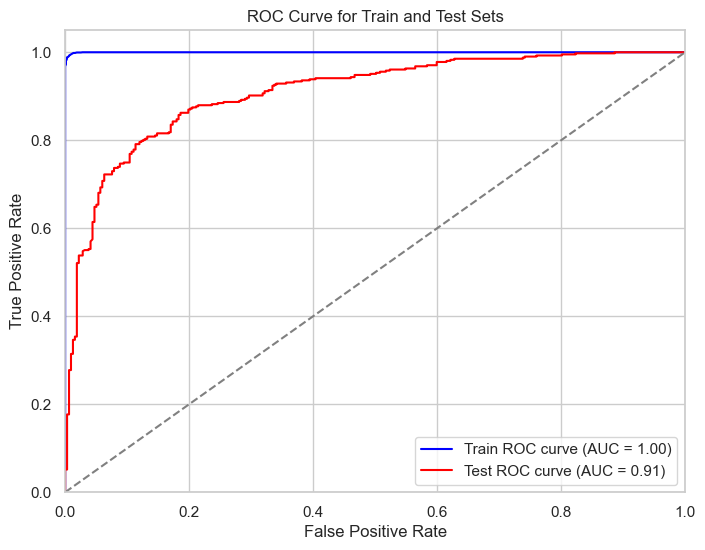

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for the training set
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train_All, y_train_pred_proba_xgb_All)
roc_auc_train_xgb = auc(fpr_train_xgb, tpr_train_xgb)

# Compute ROC curve and AUC for the test set
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test_All, y_test_pred_proba_xgb_All)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

# Plot ROC curves for both training and test sets
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label=f'Train ROC curve (AUC = {roc_auc_train_xgb:.2f})')
plt.plot(fpr_test_xgb, tpr_test_xgb, color='red', label=f'Test ROC curve (AUC = {roc_auc_test_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Train and Test Sets')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


c:\Users\xueli\miniconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\xueli\miniconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


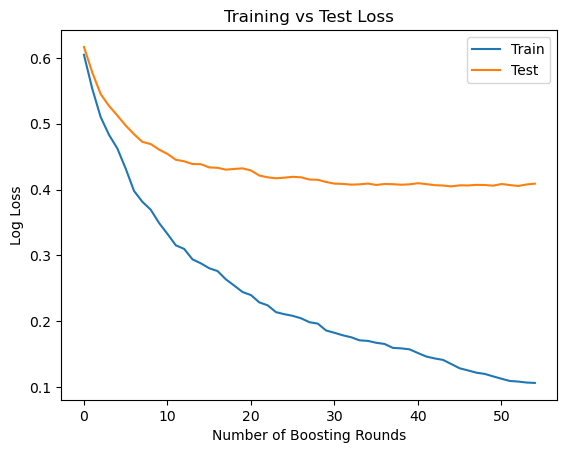

In [8]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_All)
X_test_scaled = scaler.transform(X_test_All)

# Define the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Fit the model with early stopping and validation set
xgb_model.fit(
    X_train_scaled, y_train_All,
    eval_set=[(X_train_scaled, y_train_All), (X_test_scaled, y_test_All)],
    eval_metric='logloss',
    early_stopping_rounds=10,
    verbose=False
)

# Get the evaluation results
results_xgb = xgb_model.evals_result()

# Plot training and validation loss
plt.plot(results_xgb['validation_0']['logloss'], label='Train')
plt.plot(results_xgb['validation_1']['logloss'], label='Test')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.show()


### HyperOpt

##### Exhaustive Tuning with Hyperopt

In [63]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score  

from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    This function takes a dictionary of hyperparameters, training 
    and test data, and an optional value for early stopping rounds, 
    and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training 
    data and evaluated on the test data. The loss is computed as 
    the negative of the accuracy score.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value 
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the 
        tuning process. The loss is a float, and the model is an 
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    
         
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [64]:
import xgboost as xgb

In [65]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
    'random_state': 42
}

trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train_scaled, y_train_All, 
                                                   X_test_scaled, y_test_All),            
    space=options,           
    algo=tpe.suggest,            
    max_evals=2_000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
)

100%|██████████| 2000/2000 [13:30<00:00,  2.47trial/s, best loss: -0.856353591160221]


In [66]:
best_params = best.copy()

# Cast `max_depth` (quniform) to an integer
best_params['max_depth'] = int(best_params['max_depth'])

# Cast `min_child_weight` to a float, if needed
best_params['min_child_weight'] = float(best_params['min_child_weight'])

# The rest of the parameters are ready as they are
print("Processed Best Parameters:", best_params)


Processed Best Parameters: {'colsample_bytree': 0.8676236024493804, 'gamma': 0.00016947681411963564, 'learning_rate': 0.22958011378015764, 'max_depth': 8, 'min_child_weight': 1.3638343304356748, 'reg_alpha': 0.010419315133195384, 'reg_lambda': 6.175782883994953, 'subsample': 0.6233883480464173}


In [67]:
xgb_best_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    random_state=42,
    n_estimators=500  # Large number of estimators, early stopping will choose the best
)

# Train the best model with early stopping
xgb_best_model.fit(
    X_train_scaled, y_train_All,
    eval_set=[(X_train_scaled, y_train_All), (X_test_scaled, y_test_All)],  # Train and validation sets
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds
    verbose=True  # To monitor the early stopping process
)

# Best iteration can be accessed as:
print(f"Best iteration (number of trees used): {xgb_best_model.best_iteration + 1}")



[0]	validation_0-logloss:0.61772	validation_1-logloss:0.62464
[1]	validation_0-logloss:0.57368	validation_1-logloss:0.59205
[2]	validation_0-logloss:0.52980	validation_1-logloss:0.56334
[3]	validation_0-logloss:0.49189	validation_1-logloss:0.53877
[4]	validation_0-logloss:0.46083	validation_1-logloss:0.51767
[5]	validation_0-logloss:0.43521	validation_1-logloss:0.49978
[6]	validation_0-logloss:0.41030	validation_1-logloss:0.48962
[7]	validation_0-logloss:0.39504	validation_1-logloss:0.48062
[8]	validation_0-logloss:0.38073	validation_1-logloss:0.47200
[9]	validation_0-logloss:0.36004	validation_1-logloss:0.46216
[10]	validation_0-logloss:0.34227	validation_1-logloss:0.45395
[11]	validation_0-logloss:0.32811	validation_1-logloss:0.45014
[12]	validation_0-logloss:0.31650	validation_1-logloss:0.44466
[13]	validation_0-logloss:0.30427	validation_1-logloss:0.43621
[14]	validation_0-logloss:0.29555	validation_1-logloss:0.43333
[15]	validation_0-logloss:0.28488	validation_1-logloss:0.42651
[1

c:\Users\xueli\miniconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-logloss:0.17068	validation_1-logloss:0.38573
[34]	validation_0-logloss:0.16646	validation_1-logloss:0.38475
[35]	validation_0-logloss:0.16300	validation_1-logloss:0.38248
[36]	validation_0-logloss:0.15995	validation_1-logloss:0.38141
[37]	validation_0-logloss:0.15666	validation_1-logloss:0.38153
[38]	validation_0-logloss:0.15346	validation_1-logloss:0.38024
[39]	validation_0-logloss:0.15017	validation_1-logloss:0.38088
[40]	validation_0-logloss:0.14560	validation_1-logloss:0.37903
[41]	validation_0-logloss:0.14249	validation_1-logloss:0.37712
[42]	validation_0-logloss:0.13868	validation_1-logloss:0.37505
[43]	validation_0-logloss:0.13598	validation_1-logloss:0.37575
[44]	validation_0-logloss:0.13343	validation_1-logloss:0.37403
[45]	validation_0-logloss:0.13042	validation_1-logloss:0.37134
[46]	validation_0-logloss:0.12747	validation_1-logloss:0.37234
[47]	validation_0-logloss:0.12438	validation_1-logloss:0.37086
[48]	validation_0-logloss:0.12163	validation_1-logloss:

In [68]:
# Retrieve the best number of estimators based on early stopping
best_n_estimators = xgb_best_model.best_iteration + 1  # Add 1 as it is 0-indexed

# Use the best n_estimators for final model training
final_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    random_state=42,
    n_estimators=best_n_estimators  # Set to best iteration value
)

# Train the final model on the full dataset
final_model.fit(X_train_scaled, y_train_All)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8676236024493804, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=0.00016947681411963564, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22958011378015764, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1.3638343304356748, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=63,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [69]:
from sklearn.metrics import precision_score, roc_auc_score, f1_score, accuracy_score

# Predict probabilities for AUC-ROC calculation
y_train_pred_prob = final_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_prob = final_model.predict_proba(X_test_scaled)[:, 1]

# Predict class labels
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Calculate metrics for the training set
train_precision = precision_score(y_train_All, y_train_pred)
train_auc_roc = roc_auc_score(y_train_All, y_train_pred_prob)
train_f1 = f1_score(y_train_All, y_train_pred)
train_accuracy = accuracy_score(y_train_All, y_train_pred)

# Calculate metrics for the test set
test_precision = precision_score(y_test_All, y_test_pred)
test_auc_roc = roc_auc_score(y_test_All, y_test_pred_prob)
test_f1 = f1_score(y_test_All, y_test_pred)
test_accuracy = accuracy_score(y_test_All, y_test_pred)

# Print metrics for both sets
print(f"Train Set Metrics:\nPrecision: {train_precision:.4f}\nAUC-ROC: {train_auc_roc:.4f}\nAccuracy: {train_accuracy:.4f}\nF1-Score: {train_f1:.4f}")
print("\n")
print(f"Test Set Metrics:\nPrecision: {test_precision:.4f}\nAUC-ROC: {test_auc_roc:.4f}\nAccuracy: {test_accuracy:.4f}\nF1-Score: {test_f1:.4f}")


Train Set Metrics:
Precision: 0.9892
AUC-ROC: 0.9994
Accuracy: 0.9895
F1-Score: 0.9906


Test Set Metrics:
Precision: 0.8731
AUC-ROC: 0.9168
Accuracy: 0.8356
F1-Score: 0.8499


In [70]:
# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print all hyperparameters
for param, value in params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: 0.8676236024493804
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: 0.00016947681411963564
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.22958011378015764
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 8
max_leaves: None
min_child_weight: 1.3638343304356748
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 63
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: 0.010419315133195384
reg_lambda: 6.175782883994953
sampling_method: None
scale_pos_weight: None
subsample: 0.6233883480464173
tree_method: None
validate_parameters: None
verbosity: None


#### Further hyperparameter tuning manually

##### Regularization

In [101]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for reg_lambda and reg_alpha
print(f"Current reg_alpha: {params['reg_alpha']}")
print(f"Current reg_lambda: {params['reg_lambda']}")

# Increase the values of reg_alpha and reg_lambda
params['reg_alpha'] = params['reg_alpha'] * 50  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 50  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current reg_alpha: 0.010419315133195384
Current reg_lambda: 6.175782883994953
Train Set Metrics:
Train Accuracy: 0.8647
Train Precision: 0.8743
Train AUC-ROC: 0.9385
Train F1-Score: 0.8783

Test Set Metrics:
Test Accuracy: 0.7831
Test Precision: 0.8173
Test AUC-ROC: 0.8612
Test F1-Score: 0.8040


In [110]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for reg_lambda and reg_alpha
print(f"Current reg_alpha: {params['reg_alpha']}")
print(f"Current reg_lambda: {params['reg_lambda']}")

# Increase the values of reg_alpha and reg_lambda
params['reg_alpha'] = params['reg_alpha'] * 50  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 45  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current reg_alpha: 0.010419315133195384
Current reg_lambda: 6.175782883994953
Train Set Metrics:
Train Accuracy: 0.8722
Train Precision: 0.8828
Train AUC-ROC: 0.9421
Train F1-Score: 0.8847

Test Set Metrics:
Test Accuracy: 0.7873
Test Precision: 0.8219
Test AUC-ROC: 0.8668
Test F1-Score: 0.8075


##### Regularization and max_depth

In [117]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"Current max_depth: {params['max_depth']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 4  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 48  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 48  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current max_depth: 8
Train Set Metrics:
Train Accuracy: 0.8014
Train Precision: 0.8224
Train AUC-ROC: 0.8931
Train F1-Score: 0.8199

Test Set Metrics:
Test Accuracy: 0.7652
Test Precision: 0.8078
Test AUC-ROC: 0.8417
Test F1-Score: 0.7854


##### Regularization, max_depth and min_child_weight

In [145]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"min_child_weight: {params['min_child_weight']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 4  # Decrease max_depth
params['min_child_weight'] = 1.5  # Increase min_child_weight
params['reg_alpha'] = params['reg_alpha'] * 37  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 37  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


min_child_weight: 1.3638343304356748
Train Set Metrics:
Train Accuracy: 0.8164
Train Precision: 0.8299
Train AUC-ROC: 0.9030
Train F1-Score: 0.8350

Test Set Metrics:
Test Accuracy: 0.7666
Test Precision: 0.8020
Test AUC-ROC: 0.8430
Test F1-Score: 0.7890


In [130]:
##### regulation, max_depth, min_child_weight, learning rate and n_estimators

In [148]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"learning_rate: {params['learning_rate']}")
print(f"n_estimators: {params['n_estimators']}")

# Increase the values of reg_alpha and reg_lambda
params['learning_rate'] = 0.11  # Try smaller values (e.g., 0.05 or 0.01)
params['n_estimators'] = 120  # Increase n_estimators when reducing learning_rate
params['max_depth'] = 5  # Decrease max_depth
params['min_child_weight'] = 1.5  # Increase min_child_weight
params['reg_alpha'] = params['reg_alpha'] * 48  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 48  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


learning_rate: 0.22958011378015764
n_estimators: 63
Train Set Metrics:
Train Accuracy: 0.8319
Train Precision: 0.8397
Train AUC-ROC: 0.9104
Train F1-Score: 0.8498

Test Set Metrics:
Test Accuracy: 0.7707
Test Precision: 0.8051
Test AUC-ROC: 0.8485
Test F1-Score: 0.7930


#### Add early stopping on the selected parameters based on the results above

In [149]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"Current reg_alpha: {params['reg_alpha']}")
print(f"Current reg_lambda: {params['reg_lambda']}")
print(f"Current max_depth: {params['max_depth']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 4  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 48  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 48  # Increase reg_lambda
params['early_stopping_rounds'] = 15  # Add early stopping
params['eval_metric'] = 'auc'

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All, 
                  eval_set=[(X_test_scaled, y_test_All)],
                  verbose=False)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current reg_alpha: 0.010419315133195384
Current reg_lambda: 6.175782883994953
Current max_depth: 8
Train Set Metrics:
Train Accuracy: 0.8014
Train Precision: 0.8224
Train AUC-ROC: 0.8931
Train F1-Score: 0.8199

Test Set Metrics:
Test Accuracy: 0.7652
Test Precision: 0.8078
Test AUC-ROC: 0.8417
Test F1-Score: 0.7854


In [151]:
# Get all hyperparameters of the final_model
params = final_model.get_params()

# Update parameters
params['max_depth'] = 4  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 48  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 48  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Train the model with early stopping, using the test set as validation
updated_model.fit(
    X_train_scaled, y_train_All, 
    eval_set=[(X_test_scaled, y_test_All)],  # Validation dataset is required for early stopping
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8676236024493804, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=0.00016947681411963564, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22958011378015764, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1.3638343304356748, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=63,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [152]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(updated_model, X_train_scaled, y_train_All, cv=5, scoring='precision')
print(f"Cross-validated precision: {cv_scores.mean():.4f}")


Cross-validated precision: 0.7970


In [153]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score, f1_score

# Cross-validation on the training data
scoring = ['precision', 'roc_auc', 'accuracy', 'f1']

cv_results = cross_validate(updated_model, X_train_scaled, y_train_All, cv=5, scoring=scoring, return_train_score=True)

# Display mean results for each metric on the training data
print(f"5-fold CV Mean Train Precision: {cv_results['train_precision'].mean():.4f}")
print(f"5-fold CV Mean Train AUC-ROC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"5-fold CV Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"5-fold CV Mean Train F1: {cv_results['train_f1'].mean():.4f}")

print(f"5-fold CV Mean Test Precision: {cv_results['test_precision'].mean():.4f}")
print(f"5-fold CV Mean Test AUC-ROC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"5-fold CV Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"5-fold CV Mean Test F1: {cv_results['test_f1'].mean():.4f}")

# Train the model on the full training set and evaluate on the test set
updated_model.fit(X_train_scaled, y_train_All)

# Test set performance
y_test_pred = updated_model.predict(X_test_scaled)
y_test_proba = updated_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for AUC-ROC

print(f"Test Precision: {precision_score(y_test_All, y_test_pred):.4f}")
print(f"Test AUC-ROC: {roc_auc_score(y_test_All, y_test_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_All, y_test_pred):.4f}")
print(f"Test F1: {f1_score(y_test_All, y_test_pred):.4f}")


5-fold CV Mean Train Precision: 0.8173
5-fold CV Mean Train AUC-ROC: 0.8892
5-fold CV Mean Train Accuracy: 0.7973
5-fold CV Mean Train F1: 0.8165
5-fold CV Mean Test Precision: 0.7970
5-fold CV Mean Test AUC-ROC: 0.8658
5-fold CV Mean Test Accuracy: 0.7713
5-fold CV Mean Test F1: 0.7919
Test Precision: 0.8078
Test AUC-ROC: 0.8417
Test Accuracy: 0.7652
Test F1: 0.7854


#### Save and load the model

Using pickle

In [154]:
import pickle

# Assume updated_model is your fitted model or transformer
with open('updated_model_XGBoost_sep19.pkl', 'wb') as f:
    pickle.dump(updated_model, f)


In [9]:
import pickle

# Load the saved model
with open('updated_model_XGBoost_sep19.pkl', 'rb') as f:
    updated_model = pickle.load(f)


Using joblib (often faster for larger models)

In [ ]:
'''
from joblib import dump

# Save the updated_model
dump(updated_model, 'updated_model.joblib')
'''


In [ ]:
''' 
from joblib import load

# Load the saved model
updated_model = load('updated_model.joblib')

'''

#### SHAP (SHapley Additive exPlanations)

In [155]:
test_df.shape

(724, 226)

In [10]:
import shap

# Train your model (assume model is already trained)
model = updated_model  # This is your fitted model (e.g., XGBoost, RandomForest)

# Create SHAP explainer (TreeExplainer for tree-based models like RandomForest or XGBoost)
explainer = shap.TreeExplainer(model)

# Assume X_test_scaled contains your test dataset with SMILES embeddings
shap_values = explainer.shap_values(X_test_scaled)


In [160]:
# Assuming you have already created a SHAP explainer
base_value = explainer.expected_value

# Print the base value
print(f"Base Value (Expected Value): {base_value}")


Base Value (Expected Value): 0.21249239146709442


In [161]:
import numpy as np

# Convert base value to probability if it's a logit
base_probability = 1 / (1 + np.exp(-base_value))
print(f"Base Probability: {base_probability}")


Base Probability: 0.5529241125792653


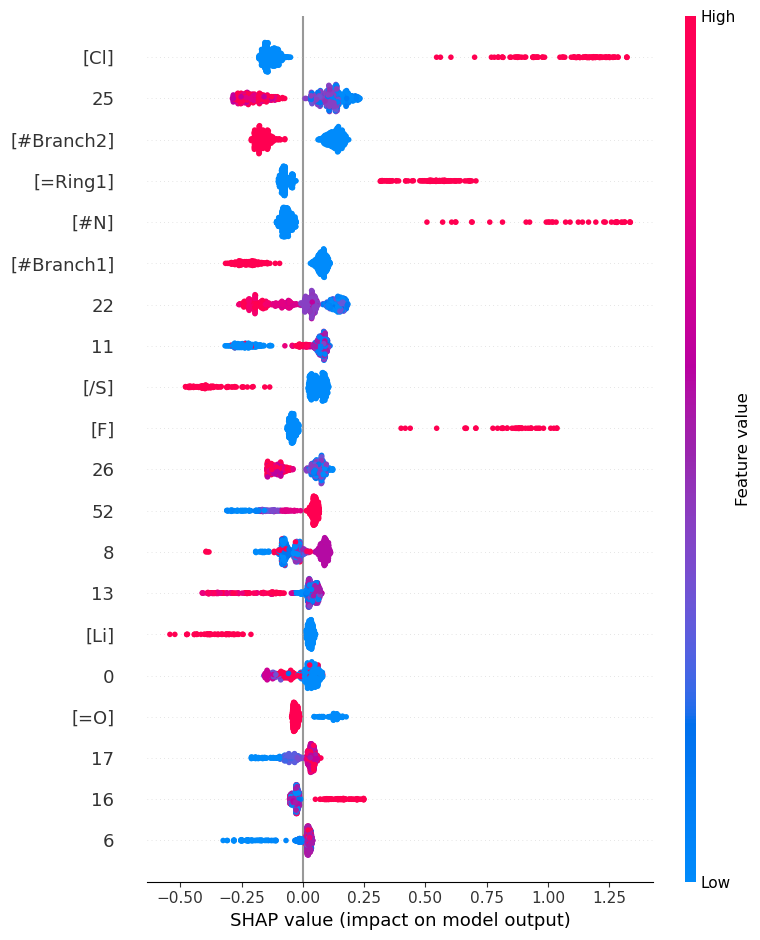

In [11]:
feature_names = X_test_All.columns.tolist()
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)


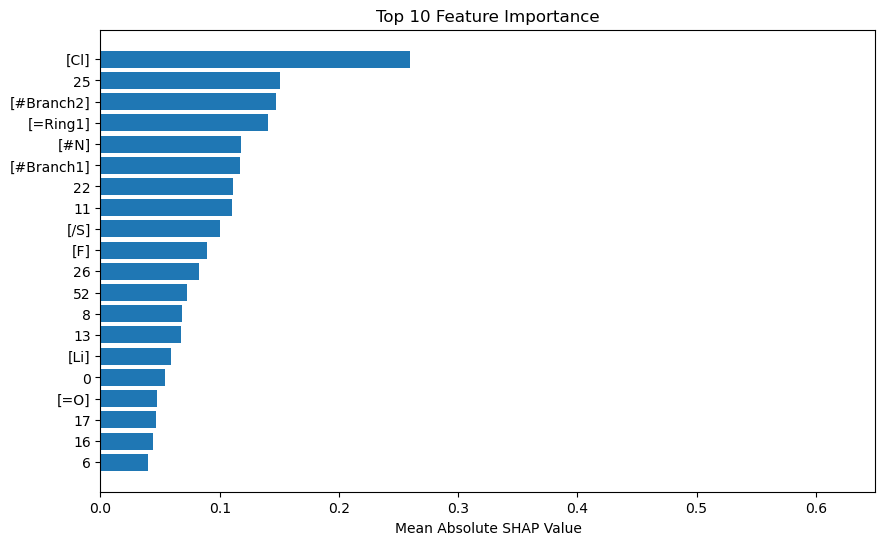

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Calculate mean absolute SHAP values for each feature
feature_importance = pd.DataFrame({
    'feature': X_test_All.columns,
    'importance': np.abs(shap_values).mean(axis=0)
})

# Sort by importance and select the top 10 features
top_20_features = feature_importance.sort_values(by='importance', ascending=False).head(20)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['feature'], top_20_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 20 Feature Importance")

# Set the x-axis limit
plt.xlim(0, 0.65)

plt.show()


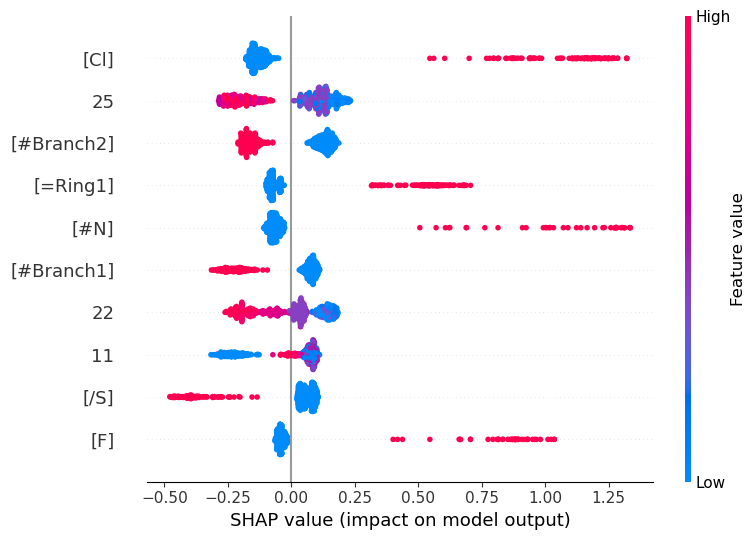

In [18]:
feature_names = X_test_All.columns.tolist()
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, max_display=10)


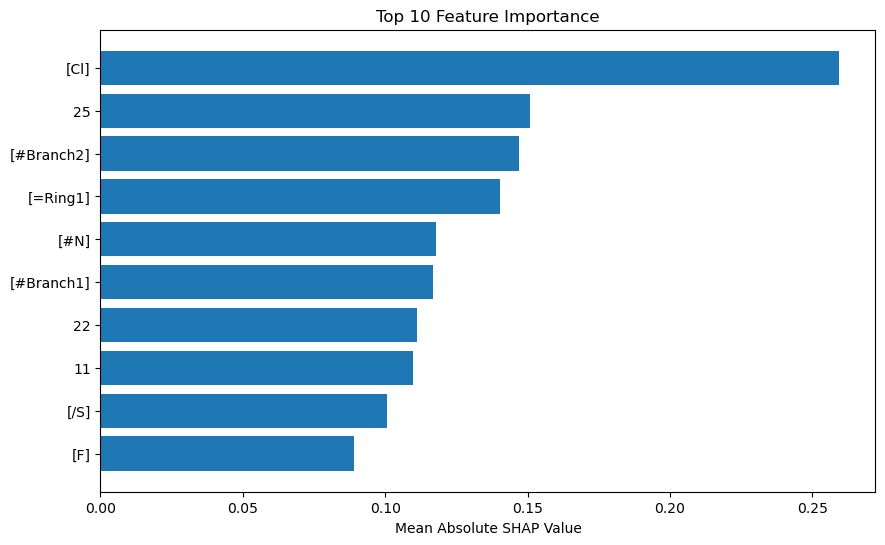

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Calculate mean absolute SHAP values for each feature
feature_importance = pd.DataFrame({
    'feature': X_test_All.columns,
    'importance': np.abs(shap_values).mean(axis=0)
})

# Sort by importance and select the top 10 features
top_10_features = feature_importance.sort_values(by='importance', ascending=False).head(10)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 10 Feature Importance")
plt.show()


Key Points:
Feature Importance: The vertical axis lists the features, ordered by their importance. The feature at the top has the highest average absolute SHAP value, indicating it has the most significant influence on the model’s predictions.

SHAP Values: The horizontal axis shows the SHAP values, which represent how much each feature contributes to the prediction compared to the baseline (expected value). Positive SHAP values push the prediction higher (toward the positive class), while negative SHAP values push it lower (toward the negative class).

Distribution of SHAP Values: Each point on the plot represents a single prediction. The spread of the points shows how feature values influence predictions across the dataset. For example, if most points for a feature are to the right, it means that higher values of that feature generally lead to higher predictions.

The scatter of points in a SHAP summary plot reflects the relationship between feature values and their influence on model predictions. Here's why you might see some points forming a line while others cluster together:

1. Linear Relationship:
Points Forming a Line: If a feature's SHAP values display a linear trend (forming a line), this suggests that the feature has a consistent and direct relationship with the model's predictions. For example, as the feature value increases, the SHAP value might also consistently increase, indicating that higher values of this feature are associated with higher predictions.
2. Non-linear Relationships:
Points Scattering: When points are more scattered and do not follow a clear trend, it may indicate a non-linear relationship between the feature and the target variable. This means that the effect of the feature on predictions varies more widely depending on other factors or feature interactions.
3. Feature Value Distribution:
Clustering: If many instances share similar feature values, the SHAP values for those instances will be similar, resulting in a cluster of points. This can happen if the feature has limited variation in the dataset.
4. Feature Interaction:
Features that interact with others may show more complex patterns in SHAP values. For instance, a feature might only have a strong impact on predictions within certain ranges of other features, leading to a more scattered representation.
5. Outliers:
Outliers or extreme values can also cause some points to scatter significantly away from the main cluster. These outliers might represent cases where the feature has an unusually strong or weak impact on the prediction.

Understanding Feature Value Colors:
Color Scale:

The color typically ranges from blue (representing lower feature values) to red (representing higher feature values). This gradient helps visualize the relationship between feature values and their impact on the model's predictions.
Impact on Predictions:

Blue Points (Low Feature Values): If a point is blue, it indicates that the feature value for that instance is low. If the SHAP value for that instance is positive, it suggests that low values of the feature push the prediction toward the positive class (if applicable).
Red Points (High Feature Values): Conversely, red points indicate high feature values. If the SHAP value is positive for these instances, it suggests that high values of the feature contribute positively to the prediction.
Trends:

By observing the color of points along with their SHAP values, you can identify trends. For example, if higher feature values (red points) correspond to higher SHAP values (pushing predictions toward the positive class), it indicates a positive relationship between the feature and the prediction.
Interactions:

The color can also reveal interactions with other features. If you see a pattern where the impact of the feature (as shown by SHAP values) changes significantly at different values (colors), it may suggest that the feature interacts with others in influencing predictions.
Summary:
Color indicates the feature value (low to high).
Position (SHAP value) indicates how much that feature contributes to the prediction.
Together, color and position help you visualize and interpret the relationship between feature values and model predictions, revealing trends and interactions in the data.

One Point = One Sample: Each point represents a single instance from your dataset—typically one molecule, corresponding to one row in your DataFrame.
Key Points:
Instance Representation: Each point’s position along the horizontal axis indicates the SHAP value for that specific instance, showing how that feature impacts the prediction for that particular row.

Feature Value: The color of the point indicates the feature value for that instance, providing additional context about how the feature's value correlates with its impact on the prediction.

Insights: By analyzing the points, you can gain insights into how different instances (molecules) are influenced by specific features in your model, helping you understand individual predictions and overall model behavior.

Summary:
So yes, each point corresponds to one sample (instance), making it easier to interpret the effects of features on predictions at an individual level within the dataset.